# R-squared explained

Here is one definition of R-squared from [Statistics By Jim](https://statisticsbyjim.com/regression/interpret-r-squared-regression/):

> R-squared is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. R-squared measures the strength of the relationship between your model and the dependent variable on a convenient 0 – 100% scale.

Definition from [scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score):
>The coefficient $ R^2 $ is defined as $ (1 - \frac{u}{v}) $, where $ u $ is the residual sum of squares ``((y_true - y_pred)** 2).sum()`` and $ v $ is the total sum of squares ``((y_true - y_true.mean()) ** 2).sum()``. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of `y`, disregarding the input features, would get a $ R^2 $ score of 0.0.

You may recall the same thing written in a slightly different way:
> $$ R^2 = 1 - \frac{RSS}{TSS} $$

#### Let's break this down into the following parts:
1. Introduce some data and make a linear regression model
1. Understand residual sum of squares (RSS)
1. Understand total sum of squares (TSS)
1. Finally just do: `1 - (RSS/TSS)`

Afterwards we will also look into the contradiction in the definitions above around whether $ R^2 $ can be negative or not, plus how to interpret the value i.e. "what is a *good* $ R^2 $ score?"

---

## Part 1 of 4 - Introduce some data and make a linear regression model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create data where each y value is x +/- 1
df = pd.DataFrame({'x':[1,2,3,4,1,2,3,4], 'y':[2,1,4,3,0,3,2,5]})
df

,x,y
0,1,2
1,2,1
2,3,4
3,4,3
4,1,0
5,2,3
6,3,2
7,4,5


### Visualise

`sns.regplot()` visualises the line of best fit through our data:

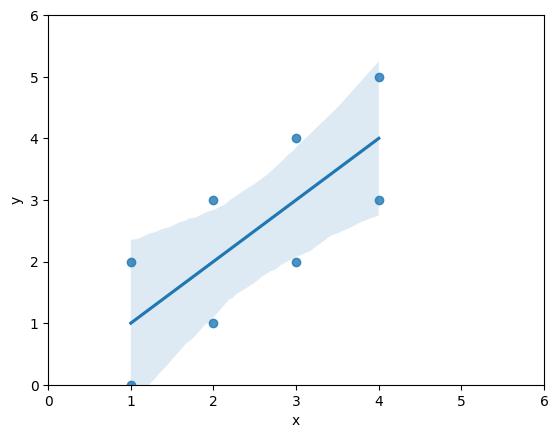

In [3]:
# there seems to be a convention to name the plot g
# perhaps for 'graph' ??
g = sns.regplot(data=df, x='x', y='y')
g.set(xlim=(0,6), ylim=(0,6));  # fix x and y axes to start at 0 and end at 6

### Build the regression model

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
X = df[['x']]
y = df['y']

In [6]:
lr = LinearRegression().fit(X,y)  # note the () after LinearRegression

What `.fit()` does:

1. Tries lines in different positions until it finds the line with the least possible error between the line and every data point aka "the line of best fit"
1. The equation of any straight line is $ y = mx + c $ where $ m $ is the coefficient (gradient) of the line and $ c$ is the intercept (where the line crosses the y-axis). Once `.fit()` has found the line of best fit it then calculates $ m $ and $ c $

Note that if we include multiple features in `X` e.g. `X = df[['feature1', 'feature2', 'feature3']]` then this will give multiple coefficients $ m $ so `.fit()` actually caluclates a **list** of coefficients i.e. [$ m_0, m_1, m_2, \ldots ,m_{x-1} $] where $ x $ is the number of features used, even if there is only one i.e. [$ m_0 $]

In [7]:
m = lr.coef_[0]  # can have multiple coefficients so this is a list, use [0] to get only the first value
c = lr.intercept_
print(f'Equation for line of best fit from LR model: y = {m}x + {c}')  # note f before '' makes {m} and {c} work

Equation for line of best fit from LR model: y = 1.0x + 0.0


*NB - the data were chosen deliberately so that m=1 and c=0 to keep things simple. Both the coefficient and the intercept can take any value (including negative values) and in the real world are rarely as neat and tidy as in this artificial example.*

## Part 2 of 4 - Understand residual sum of squares (RSS)

For each *x* value in `df['x']` we know the **true** value of *y* which we have in `df['y']`.

We can now use our newly fitted linear regression module to **predict** the value of *y* for each value of *x*.

In [8]:
# use the model i.e. put each x value into equation y = 1x + 0
y_pred = lr.predict(X)
y_pred

array([1., 2., 3., 4., 1., 2., 3., 4.])

In [9]:
# store these values in our dataframe to see better what we have got
df['y_pred'] = y_pred
df

,x,y,y_pred
0,1,2,1.0
1,2,1,2.0
2,3,4,3.0
3,4,3,4.0
4,1,0,1.0
5,2,3,2.0
6,3,2,3.0
7,4,5,4.0


Unless our model is perfect, there will be a **difference** between the true value of each *y* and our predicted *y*. The difference between two values is also called the *residual*.

We have also talked about the difference between true *y* and predicted *y* using the word *error* which is also appropriate.

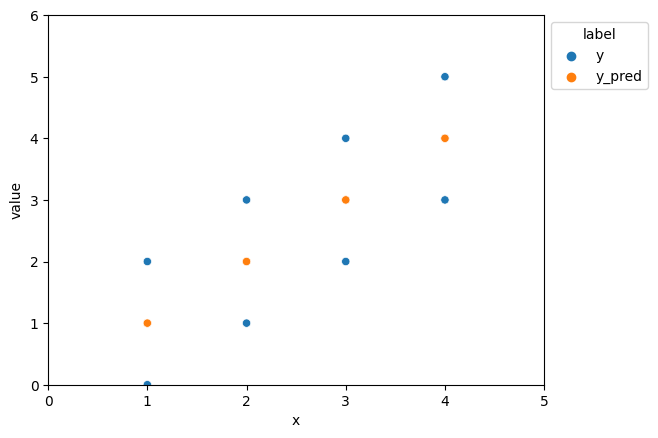

In [10]:
# let's try and visualise this
# adapted from https://stackoverflow.com/questions/44941082/plot-multiple-columns-of-pandas-dataframe-using-seaborn
df_melted = df.melt('x', var_name='label', value_name='value')
g = sns.scatterplot(data=df_melted, x='x', y='value', hue='label')
g.set(xlim=(0,5), ylim=(0,6));
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

*NB - there are 8 predictions, one for each value of x, but we see only 4 orange dots because some of the prediction values are the same, therefore we have dots on top of each other so only 4 are visible. One solution would be to chop the data into two halves:*

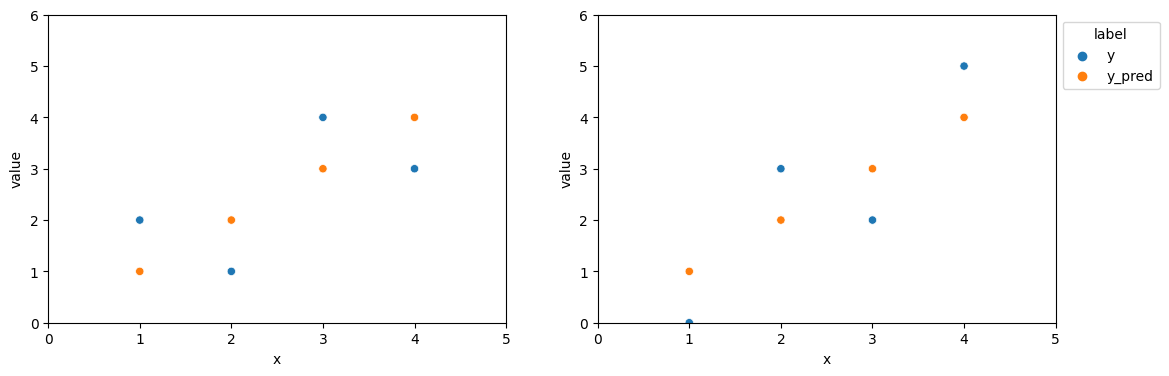

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

df_melted_0 = df[:4].melt('x', var_name='label', value_name='value')
sns.scatterplot(data=df_melted_0, x='x', y='value', hue='label', ax=ax[0], legend=None)
ax[0].set(xlim=(0,5), ylim=(0,6))

df_melted_1 = df[4:].melt('x', var_name='label', value_name='value')
sns.scatterplot(data=df_melted_1, x='x', y='value', hue='label', ax=ax[1])
ax[1].set(xlim=(0,5), ylim=(0,6));
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))

Two takeaways:
1. the predictions all appear on the line calculated by `.fit(X,y)` as this is how linear regression modelling works! Remember our data was chosen deliberately so that m=1 and c=0 to keep things simple in this example.
1. the difference (aka the *residual*, aka the *error*) between the true value of `y` (blue dot) and `y_pred` (orange dot) is either +1 or -1

### What does this have to do with the "residual sum of squares (RSS)" ?

In the scikit learn definition at the top of this page we had:

> $ R^2 $ is defined as $ (1 - \frac{u}{v}) $, where $ u $ is the residual sum of squares ``((y_true - y_pred)** 2).sum()``

Now we have both `y_true` (in `df['y']`) and also `y_pred` (in `df['y_pred']`) we can calculate $ u $ aka $ RSS $

In [12]:
# calculate the difference (residual) between y_true and y_pred for each value of x
residuals = df['y'] - df['y_pred']
residuals

0    1.0
1   -1.0
2    1.0
3   -1.0
4   -1.0
5    1.0
6   -1.0
7    1.0
dtype: float64

In [13]:
# square each residual
# NB in python we use **2 to square a number, in other languages this would be ^2
residual_squares = residuals**2
residual_squares

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
dtype: float64

In [14]:
# sum the squared residuals to give the "residual sum of squares"
rss = residual_squares.sum()
rss

8.0

So in our example the $ RSS = 8 $

#### Aside: RSS and MSE
We mentioned that these 'residuals' could also be described as 'errors' since they are the difference between each true value of *y* and the value of *y* predicted by our model.

In fact, $ RSS $ is very closely related to the *mean squared error* metric ($ MSE $) that we used in the linear regression bootcamp. Except that instead of the word *residual* we are using *error* and instead of  calculating the *residual **sum** of squares* we calculate the ***mean*** *squared error*.

In [15]:
# show that the *mean* of our residual squares is 1.0
residual_squares.mean()

1.0

In [16]:
# import the MSE metric like we did in the bootcamp
from sklearn.metrics import mean_squared_error

In [17]:
# show that the mean squared error is also 1.0
mean_squared_error(y, y_pred)

1.0

## Part 3 - Understand total sum of squares (TSS)

As you might guess from the similar name $ TSS $ is calculated in a similar way to $ RSS $. The difference being that in $ TSS $ we are interested in the difference between each *y* value and the **mean of all our *y* values**, whereas in $ RSS $ above we calculated the difference between each *y* and the **predicted value of *y* given by our model**.

We can see this similarity further by putting the relevant parts of the scikit learn equation side by side:

$ u $ aka $ RSS $ ``((y_true - y_pred)** 2).sum()``

$ v $ aka $ TSS $ ``((y_true - y_true.mean()) ** 2).sum()``

In [18]:
# calculate the mean of y
y_mean = df['y'].mean()
y_mean

2.5

In [19]:
# store in our dataframe so that we can plot it
df['y_mean'] = y_mean
df

,x,y,y_pred,y_mean
0,1,2,1.0,2.5
1,2,1,2.0,2.5
2,3,4,3.0,2.5
3,4,3,4.0,2.5
4,1,0,1.0,2.5
5,2,3,2.0,2.5
6,3,2,3.0,2.5
7,4,5,4.0,2.5


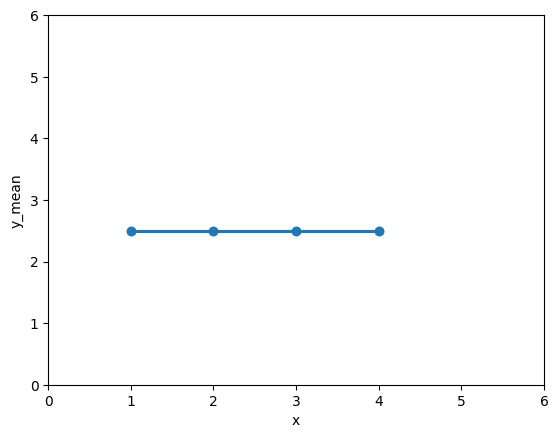

In [20]:
# re-use code from earlier but change y to y='y_mean'
g = sns.regplot(data=df, x='x', y='y_mean')
g.set(xlim=(0,6), ylim=(0,6));

In a similar way to before, let's look at the difference between each true *y* value and `y_mean`

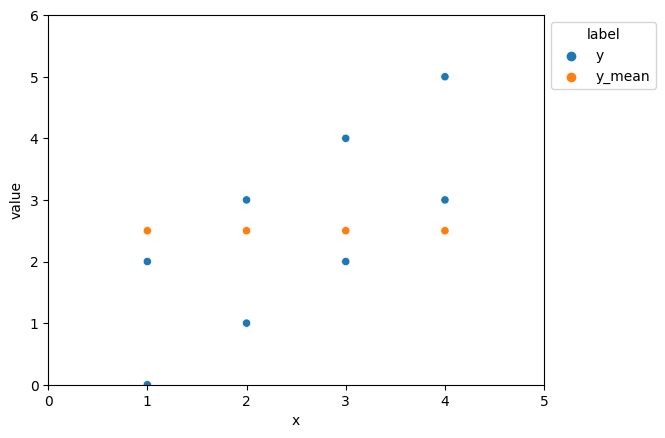

In [21]:
# visualise this with our data
# NB use of .drop() to exclude the y_pred column from this visualisation
df_melted = df.drop(columns=['y_pred']).melt('x', var_name='label', value_name='value')
g = sns.scatterplot(data=df_melted, x='x', y='value', hue='label')
g.set(xlim=(0,5), ylim=(0,6));
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

*NB - again, there are 8 orange dots here, just some are on top of each other*

In [22]:
# previously we looked at the difference (residuals/error) between y and y_pred for each value of x
# here we do similar but looking at the difference between y and y_mean
diff = df['y'] - df['y_mean']
diff

0   -0.5
1   -1.5
2    1.5
3    0.5
4   -2.5
5    0.5
6   -0.5
7    2.5
dtype: float64

In [23]:
# square them
diff_squares = diff**2
diff_squares

0    0.25
1    2.25
2    2.25
3    0.25
4    6.25
5    0.25
6    0.25
7    6.25
dtype: float64

In [24]:
# sum the squares to give the "total sum of squares"
tss = diff_squares.sum()
tss

18.0

We previously calculated that our $ RSS = 8 $ and now we have $ TSS = 18 $

## Part 4 of 4 - Finally just do $ 1 - (RSS/TSS) $

In [25]:
1 - (rss/tss)

0.5555555555555556

In [26]:
# does this match the R-squared score given by scikit learn?
lr.score(X,y)

0.5555555555555556

#### How to use `.score()`

The `.score()` function can cause confusion around what values should be used - for example should the *y* values be `y` or `y_pred` or even something else entirely?

Here is a simplified version of the [scikit learn documentation for `.score()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score):

>**Parameters:**
>
>**X** - test samples
>
>**y** - true values of `X`
>
>**Returns:**
>
>**score** - $ R^2 $ of `self.predict(X)` wrt `y` 

This tells us that the first parameter needs to be our *X* values. As noted in the final line, these *X* values will be used to do `y_pred = predict(X)` "under the hood" and then in turn these `y_pred` values will be compared to the second parameter, the true *y* value for each *X*, to calculate the $ R^2 $ score.

Takeaway:

This is correct `lr.score(X, y)`

This would be wrong `lr.score(X, y_pred)` because although it might *feel* like the right thing to do, this would take our predicted *y* values and compare them with the predicted *y* values calculated by `.score()` which would always give a score of 1 since we are comparing values with themselves!

In [27]:
# demonstrating what happens if we do lr.score(X, y_pred) by mistake
lr.score(X, y_pred)

1.0

---

## Interpreting the score

Having seen how to calculate $ R^2 $ it is important to understand how to interpret this score and to be clear on whether the score can ever be a negative number or not.

### What the score actually tells us

Let's return to the definition of $ R^2 $ from Statistics By Jim earlier, which includes the line:

> This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively.

The *dependent variable* is the feature we put on the y-axis and is the thing that we are investigating/modeling, for example this might be the number of bike rentals on a given day.

The *independent variables* are the features (one or more) we put on the x-axis and are the things that we think might influence the feature that we are investigating/modeling, for example daily temperature or if a given day is a workday in the bike rentals scenario.

In our example above we got a score of 0.5555555555555556 which means that we can say **"55.56% of the variance in *y* can be explained by *X*"**. Conversely, this implies that there is 44.44% which is explained by other features that we have not included in our model.

The word *variance* is key and has a set definition in statistics. *Variance* [can be defined as follows](https://www.scribbr.com/statistics/variance/):
> The variance is a measure of variability. It is calculated by taking the average of squared deviations from the mean.

In other words, some of *y* values will be quite close to the mean value of *y*, some values will be further away. Our $ R^2 $ score tells us *how much* (what percentage) of this variation is explained by our model.

#### Aside: $ RSS $ and $ TSS $ are closely related to mean squared error and variance

Both $ RSS $ and *mean squared error* use the squared deviations from the predicted values from our model. Again, the only difference is that $ RSS $ uses sum whereas *mean squared error* uses the average.

Both $ TSS $ and *variance* use the squared deviations from the mean of *y*, the only difference is that $ TSS $ uses the sum of these whereas *variance* uses the average.

### What is a "good" score?

This almost entirely **depends on the context** in which you are working. Let's say your model has $ R^2 = 0.3 $ so less than a third of the variation in your *y* variable is explained by your model. You might think that this is not very good. In most real-world scenarios, however, the are a **huge** number of factors that could have an impact on the thing that you are trying to model.

Take bike rentals. How many crazy factors could you dream up that could feasibly affect the number of people that decide to hire a bicycle on any given day? Here are some ideas:

* what condition are the local cycle routes in?
* is there an event on which might drive hires up? (Or down?)
* is there a social media craze going on for kids filming themselves on hire bikes?
* how is the economy doing, do people have spare money for bike rides?

There could be **literally millions** of potential factors, so having 30% of the variation explained by your model is good.

If instead you are doing some sort of highly controlled, scientific study and there is literally only one or two other factors that could potentially affect your *y* values, then having only 30% explained by your model is rubbish - try modelling those other factors instead!

It also depends on exactly **what are you trying to achieve** with your model. Knowing that a full 30% of the variation in bike hires is explained by only one or two factors could be a hugely valuable insight for this business. If instead they are trying to create a really robust model which accurately predict bike hires in the future then 0.3 is unlikely to cut it - but even then the business should remember that [predicting the future is hard](http://www.rinkworks.com/said/predictions.shtml) bordering on impossible.

Lastly, it is worth noting that a partiucularly high score for a predictive model is not a good idea as this would suggest that the model has been overfitted.

It is worth reading the whole [Statistics By Jim piece on R-squared](https://statisticsbyjim.com/regression/interpret-r-squared-regression/) for how to interpret scores but bear in mind that it does include an error when it says that R-squared is always between 0 and 100%, because R-squared can be negative.

### How can a square number ever be negative?

Basic maths says that any number which has been squared (multiplied by itself) cannot have a negative value because a negative number multiplied by another negative number (in this case, itself) gives a positive number!

There are many sources on the internet which claim that R-squared will always be $0 <= R^2 <= 1$ such as the Statistics By Jim piece above.

Where does this confusion come from? Let's start by understanding R.

#### What is $ R $

$ R $ is a common shorthand for [Pearson's correlation coefficient](https://en.wikipedia.org/wiki/Correlation_coefficient) which is the basic measure of correlation that we are familar with, where +1 is a perfect positive correlation, -1 is a perfect negative correlation, and everything in between.

We have used the `.corr()` function before, often to make a heatmap:

In [28]:
df.corr()

,x,y,y_pred,y_mean
x,1.000000,0.745356,1.000000,NaN
y,0.745356,1.000000,0.745356,NaN
y_pred,1.000000,0.745356,1.000000,NaN
y_mean,NaN,NaN,NaN,NaN


<AxesSubplot: >

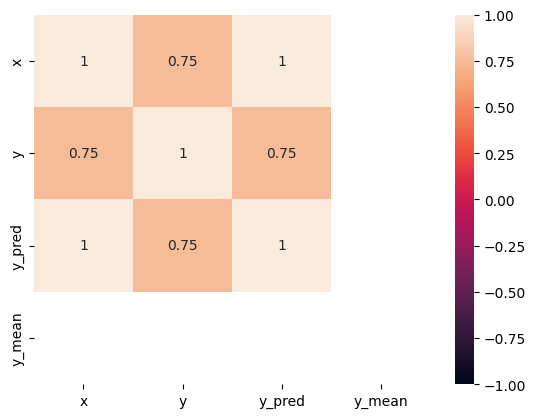

In [29]:
# make a heatmap of these correlations
sns.heatmap(data=df.corr(), annot=True, vmin=-1, vmax=1)

#### R-squared *is* indeed $ R^2 $

In [30]:
# grab only the correlation between x and y from the correlation table
R = df.corr()['x']['y']
R

0.74535599249993

In [31]:
# and square it using the power operator which is ** in python
R**2

0.5555555555555557

In [32]:
# this matches
lr.score(X,y)

0.5555555555555556

We have shown that R-squared is indeed a number ($ R $ the correlation between *x* and *y* in our model) multiplied by itself, therefore it *has to be positive*. This helps explain why lots of sources claim that R-squared must always be between 0 and 1.

Which begs the question: how can R-squared ever be negative? Are we about to re-write the rules of maths?!

The first thing to understand is there is a boring, practical reason why R-squared should never be negative, which is that any model with $ R^2 < 0 $ *should not be used* since a negative R-squared value tells us that the model is less good than simply using the mean of *y* to predict all our *y* values.

This is because, by definition, a model which used `y_mean` to predict all the *y* values would have an R-squared score of 0. To understand why, look again at the relevant parts of the scikit learn equation side by side:

>$u$ aka $RSS$ ``((y_true - y_pred) ** 2).sum()``
>
>$v$ aka $TSS$ ``((y_true - y_true.mean()) ** 2).sum()``

If we use the mean of *y* (which scikit learn refers to as `y_true.mean()`) in place of `y_pred` in the RSS formula then we get:

>$u$ aka $RSS$ ``((y_true - y_true.mean()) ** 2).sum()``
>
>$v$ aka $TSS$ ``((y_true - y_true.mean()) ** 2).sum()``

Our RSS and TSS are now the same!

If $RSS = TSS$ then $R^2$ will always be 0 because any value divided by itself is 1 as shown here:

$$ 
\begin{align}
R^2 &= 1 - \frac{RSS}{TSS} \\[10pt]
 &= 1 - \frac{TSS}{TSS} \\[10pt]
 &= 1 - 1 \\[10pt]
 &= 0
\end{align}
$$

We would usually choose to use the model with the better score, and given that zero is greater than some negative number, we would choose to use the mean of *y* as our model. Even though zero is still rubbish, it is better than less than zero!

### Proof that R-squared can be negative

So far we have explained why not to use a model with R-squared less than zero but not yet shown how this can happen in the first place. Three possible scenarios which could lead to a negative R-squared score:

1. Multiple features on the x axis
1. The model has `fit_intercept=False`
1. User error

#### Multiple features on the x axis

In our model above we had only one feature in `X` therefore we could caluclate the correlation $ R $ between `x` and `y`. If there are *multiple* features in `X` then there will also be *multiple* correlations, one from each `x` to `y`. It is **not** possible to calculate a combined $ R $, therefore when we have multiple features effectively *there is no $ R $*.

This explains how it is possible to have a negative R-squared score even though it is the square of $ R $ since this is true **if and only if** we have just a single independent variable *x* in the model.

#### The model has `fit_intercept=False`

The [scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) tells us that `LinearRegression()` can take the following parameters:

> sklearn.linear_model.LinearRegression(\*, *fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False*)

Here we will look at `fit_intercept` which we can see has the default value `True` so the model will calculate the intercept value *c* for the line of best fit.

If we explicitly set `fit_intercept=False` then the model will not calculate the intercept so *c* will always be zero. This is almost always a bad idea as we will demonstrate here, which is why the default is `fit_intercept=True`.

There is a very small number of [complex special cases](https://stats.stackexchange.com/questions/7948/when-is-it-ok-to-remove-the-intercept-in-a-linear-regression-model) when you might need to force `c=0`. 

In [33]:
# create some data that has m=-1 and c=8 
# i.e. a negative gradient and the intercept at 8
df_fit_demo = df[['x','y']].copy()
df_fit_demo['y'] = 8 - df_fit_demo['y']
df_fit_demo

,x,y
0,1,6
1,2,7
2,3,4
3,4,5
4,1,8
5,2,5
6,3,6
7,4,3


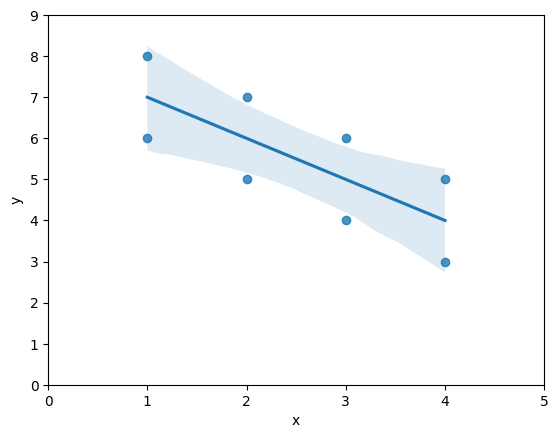

In [34]:
# visualise what the line of best fit *should* look like
g = sns.regplot(data=df_fit_demo, x='x', y='y')
g.set(xlim=(0,5), ylim=(0,9));

In [35]:
X_fit_demo = df_fit_demo[['x']]
y_fit_demo = df_fit_demo['y']

In [36]:
# create two models:
# lr_t (t for true) with default, which is fit_intercept=True
lr_t = LinearRegression().fit(X_fit_demo, y_fit_demo)

# lr_f (f for false) with fit_intercept=False 
lr_f = LinearRegression(fit_intercept=False).fit(X_fit_demo, y_fit_demo)

In [37]:
# print equation for lr_t which has fit the intercept, data selected such that c=8
m_t = lr_t.coef_[0]
c_t = lr_t.intercept_
print(f'Equation for line of best fit from lr_t model: y = {m_t}x + {c_t}')

Equation for line of best fit from lr_t model: y = -1.0x + 8.0


In [38]:
# print equations for lr_f which has not fit the intercept, so c=0
m_f = lr_f.coef_[0]
c_f = lr_f.intercept_
print(f'Equation for line of best fit from lr_f model: y = {m_f}x + {c_f}')

Equation for line of best fit from lr_f model: y = 1.666666666666667x + 0.0


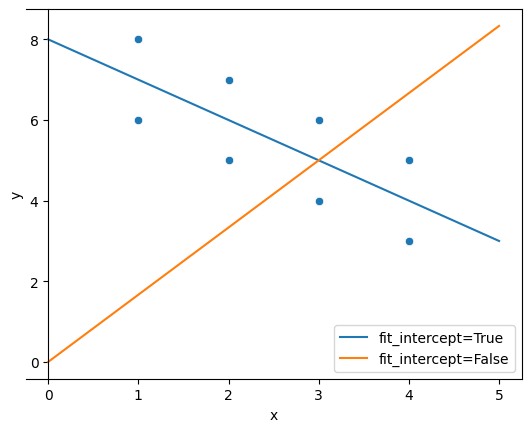

In [39]:
# to plot lines we need to create values for the x axis
x = pd.DataFrame({'x': [0,1,2,3,4,5]})
fig, ax = plt.subplots()

# plot LR equations using plot(x, y, label) where y = mx+c
plt.plot(x, m_t*x + c_t, label='fit_intercept=True')
plt.plot(x, m_f*x + c_f, label='fit_intercept=False')

# plot the data 
sns.scatterplot(data=df_fit_demo, x='x', y='y')

# draw the y axis at zero to show the intercept clearly
ax.spines['left'].set_position('zero')  

When the intercept is not fitted then it is left as zero. By definition the line will therefore always cross the x axis at zero.

This can put the line in a really bad place which does not fit the data at all well, like we have here. If the fit is so bad that it is worse than simply using the mean of *y* then R-squared will be negative.

In [40]:
# the R-squared score of our lr_t model should be pretty good
lr_t.score(X_fit_demo, y_fit_demo)

0.5555555555555556

In [41]:
# the R-squared score of our lr_f model should be really, really bad
lr_f.score(X_fit_demo, y_fit_demo)

-4.185185185185186

#### User error

It can be easy to lose track of what everything is when working in a notebook like this. You might have mutliple models, you might also have multiple sources of data stored in different dataframes, you might also have extra layers of complexity such as train-test split or standardisation (neither of which we have covered here).

It can also be easy to accidently overwrite a variable, such as `X`, with some other values which can lead to confusion.

If we do not pass the correct data into the `.score(X,y)` function then we can get highly unexpected R-squared scores which might even be negative:

In [42]:
lr.score(X,y_fit_demo)

-5.666666666666667

What has happened here? The model named `lr` was made at the start of this notebook using the data from `X` so this is correct so far. However, the *y* values in `y_fit_demo` are from a completely different data source - nothing to do with the values in `X` and also nothing to do with the values of *y* that were used when we did `lr.fit(X,y)`.

It is both possible and necessary sometimes to score a linear regression model with some other values of *y* that were not used to fit the model (which is the core principle of train-test split) but we need to make sure that what we do with `.score(X,y)` makes sense to avoid funky results.

---

## Further reading

Some of these have been included in the above notebook, others are additional sources:

**Scikit learn**
* [LinearRegression documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) on scikit learn

**R-squared**
* [How To Interpret R-squared in Regression Analysis](https://statisticsbyjim.com/regression/interpret-r-squared-regression/) on Statistics By Jim
* [Why am I seeing a negative R^2 value?](https://help.desmos.com/hc/en-us/articles/202529139-Why-am-I-seeing-a-negative-R-2-value-) a nice, short explanation on desmos.com
* [R-Squared](https://www.investopedia.com/terms/r/r-squared.asp) on investopedia.com - includes an excellent section on 'what is a good R-squared value?' in the context of investing
* [What’s a good value for R-squared?](https://people.duke.edu/~rnau/rsquared.htm) part of a comprehensive, academic series for anyone who wants to really understand linear regression analysis


**The intercept (c)**

* [When is it OK to remove the intercept in a linear regression model](https://stats.stackexchange.com/questions/7948/when-is-it-ok-to-remove-the-intercept-in-a-linear-regression-model) a slightly technical discussion on Cross Validated
* [How to Interpret the Constant (Y Intercept) in Regression Analysis](https://statisticsbyjim.com/regression/interpret-constant-y-intercept-regression/) on Stats By Jim

**Correlation (R)**

* [Correlation coefficient](https://en.wikipedia.org/wiki/Correlation_coefficient) on wikipedia
* [How to Interpret a Correlation Coefficient r](https://www.dummies.com/article/academics-the-arts/math/statistics/how-to-interpret-a-correlation-coefficient-r-169792/) by Statistics For Dummies